# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


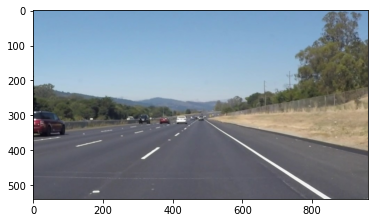

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [126]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def get_line_from_slope_intercept(slope, intercept):
    startY = imshape[0]
    endY = 315
    startX = (startY - intercept) / slope
    endX = (endY - intercept) / slope
    
    return [(int(startX), int(startY)), (int(endX), int(endY))]

def extrapolate_lines_polyfit(lines):
    n = 1
    x1Avg = 0
    x2Avg = 0
    y1Avg = 0
    y2Avg = 0
    for line in lines:
         for x1,y1,x2,y2 in line:
            x1Avg = x1Avg + (x1 - x1Avg)/n
            x2Avg = x2Avg + (x2 - x2Avg)/n
            y1Avg = y1Avg + (y1 - y1Avg)/n
            y2Avg = y2Avg + (y2 - y2Avg)/n
            n += 1
    
    [slope, intercept] = np.polyfit([x1Avg, x2Avg], [y1Avg, y2Avg], 1)
    print("Slope", slope)
    print("Intercept", intercept)
    
    return get_line_from_slope_intercept(slope, intercept)

def extrapolate_lines_fitline(lines):
    points = []
    for line in lines:
         for x1,y1,x2,y2 in line:
            points.append((x1,y1))
            points.append((x2,y2))

    [vx,vy,x,y] = cv2.fitLine(np.array(points, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)
    slope = vy / vx
    intercept = y - (slope * x)
    print("Slope", slope)
    print("Intercept", intercept)
    
    return get_line_from_slope_intercept(slope, intercept)

def draw_lines(img, lines, color=[255, 255, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_side = []
    right_side = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if slope < 0:
                left_side.append(line)
            else:
                right_side.append(line)
    
    left_line_poly = extrapolate_lines_polyfit(left_side)
    left_line_fit = extrapolate_lines_fitline(left_side)

    right_line_poly = extrapolate_lines_polyfit(right_side)
    right_line_fit = extrapolate_lines_fitline(right_side)
    cv2.line(img, left_line_fit[0], left_line_fit[1], color, thickness)
    cv2.line(img, right_line_fit[0], right_line_fit[1], color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [127]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Slope -0.6788321167883185
Intercept 636.7372262773712
Slope [-0.67861766]
Intercept [636.6596]
Slope 0.6389201349831267
Intercept -0.017716535432884616
Slope [0.64020365]
Intercept [-0.88809204]


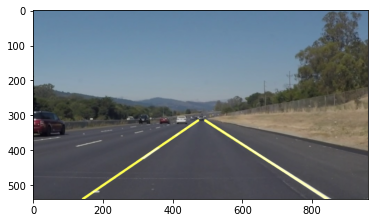

In [128]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def detect_lines(image):
    # gray scale image
    gray = grayscale(image)

    # blur image 
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # detect edges with a gradient filter
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # create a mask for the high interest area
    vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # detect lines using hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    weighted = weighted_img(line_img, image)

    plt.imshow(weighted, cmap='gray')


detect_lines(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [129]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [130]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # gray scale image
    gray = grayscale(image)

    # blur image 
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # detect edges with a gradient filter
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # create a mask for the high interest area
    vertices = np.array([[(0,imshape[0]),(490, 300), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # detect lines using hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    weighted = weighted_img(line_img, image)
    return weighted

Let's try the one with the solid white lane on the right first ...

In [131]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   6%|▌         | 13/221 [00:00<00:01, 120.85it/s, now=None]

Slope -0.7475490196078439
Intercept 661.5149286987524
Slope [-0.73810244]
Intercept [658.15625]
Slope 0.6093749999999999
Intercept 14.376736111111319
Slope [0.615768]
Intercept [10.329956]
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

Slope -0.7475490196078439
Intercept 661.5149286987524
Slope [-0.73810244]
Intercept [658.15625]
Slope 0.6093749999999999
Intercept 14.376736111111319
Slope [0.615768]
Intercept [10.329956]
Slope -0.7225244831338407
Intercept 652.1992201668476
Slope [-0.728101]
Intercept [654.0383]
Slope 0.5980582524271855
Intercept 20.669902912620426
Slope [0.61399364]
Intercept [10.121887]
Slope -0.6938483547925628
Intercept 643.1932631031351
Slope [-0.7165393]
Intercept [650.8804]
Slope 0.6104014598540156
Intercept 13.484986728599251
Slope [0.6199466]
Intercept [7.0975647]
Slope -0.71523178807947
Intercept 649.1383370125089
Slope [-0.72975814]
Intercept [653.6996]
Slope 0.6167247386759585

t:  17%|█▋        | 38/221 [00:00<00:01, 115.26it/s, now=None]

Slope -0.6199376947040515
Intercept 613.4725856697827
Slope [-0.67845416]
Intercept [637.34143]
Slope 0.6357878068091852
Intercept 2.2189231987326994
Slope [0.6362242]
Intercept [1.903717]
Slope -0.6743243243243232
Intercept 633.9513513513508
Slope [-0.6900042]
Intercept [640.1083]
Slope 0.6369168356997983
Intercept 2.0185091277882012
Slope [0.64274013]
Intercept [-1.9733582]
Slope -0.6871794871794848
Intercept 639.4747863247854
Slope [-0.70155174]
Intercept [644.80927]
Slope 0.6339285714285701
Intercept 4.04241071428678
Slope [0.65224]
Intercept [-8.111786]
Slope -0.708618331053352
Intercept 646.1132390940876
Slope [-0.7112262]
Intercept [647.0436]
Slope 0.6197916666666677
Intercept 12.46249999999917
Slope [0.64905244]
Intercept [-6.1473694]
Slope -0.6988795518207251
Intercept 641.2049019607833
Slope [-0.6936374]
Intercept [639.59033]
Slope 0.6325051759834375
Intercept 2.1866177300956195
Slope [0.6316833]
Intercept [2.7236938]
Slope -0.6813602015113385
Intercept 636.9165617128474
Slop

t:  23%|██▎       | 50/221 [00:00<00:01, 96.13it/s, now=None] 

Slope -0.6700000000000007
Intercept 629.5250000000004
Slope [-0.6753254]
Intercept [631.64185]
Slope 0.6635514018691581
Intercept -18.925233644859034
Slope [0.648417]
Intercept [-8.575806]
Slope -0.6583629893238422
Intercept 624.924199288256
Slope [-0.68689156]
Intercept [636.1787]
Slope 0.6562211981566806
Intercept -13.603993855605886
Slope [0.6576754]
Intercept [-14.576904]
Slope -0.662576687116564
Intercept 627.0851226993864
Slope [-0.6959272]
Intercept [639.9813]
Slope 0.6620808254514191
Intercept -17.4935511607914
Slope [0.6449259]
Intercept [-6.416931]
Slope -0.7026315789473698
Intercept 641.679385964913
Slope [-0.7267153]
Intercept [650.3375]
Slope 0.6474358974358978
Intercept -7.4893162393165005
Slope [0.66024965]
Intercept [-15.899384]
Slope -0.693997071742315
Intercept 637.5190336749641
Slope [-0.6991375]
Intercept [639.3909]
Slope 0.6587947882736138
Intercept -15.093783930509225
Slope [0.649746]
Intercept [-9.278442]
Slope -0.6891891891891891
Intercept 638.4999999999999
Slop

t:  32%|███▏      | 70/221 [00:00<00:01, 85.45it/s, now=None]

Slope -0.674796747967479
Intercept 630.4928861788616
Slope [-0.67879456]
Intercept [632.0773]
Slope 0.6065276518585675
Intercept 23.21808291436578
Slope [0.64514005]
Intercept [-2.5942993]
Slope -0.6235294117647033
Intercept 612.0117647058811
Slope [-0.6700073]
Intercept [630.4054]
Slope 0.6197718631178708
Intercept 12.869296577946711
Slope [0.65198207]
Intercept [-7.503662]
Slope -0.621342512908776
Intercept 611.0663880009828
Slope [-0.67254806]
Intercept [630.7622]
Slope 0.62641898864809
Intercept 8.053663570691791
Slope [0.6434235]
Intercept [-2.0385132]
Slope -0.6576032225579062
Intercept 625.2206277274256
Slope [-0.67574835]
Intercept [631.7582]
Slope 0.6659772492244047
Intercept -16.080455015511333
Slope [0.6457113]
Intercept [-3.747589]
Slope -0.6355329949238585
Intercept 619.5006526468458
Slope [-0.67025965]
Intercept [630.4681]
Slope 0.6586345381526104
Intercept -10.102409638554038
Slope [0.6603275]
Intercept [-11.1979065]
Slope -0.6212765957446794
Intercept 613.1282674772029


t:  40%|███▉      | 88/221 [00:00<00:01, 83.65it/s, now=None]

Slope [0.6523379]
Intercept [-7.3423767]
Slope -0.6632860040567959
Intercept 623.6664976335366
Slope [-0.66720486]
Intercept [624.9225]
Slope 0.6599597585513085
Intercept -11.924978442081617
Slope [0.6488287]
Intercept [-4.608673]
Slope -0.6283950617283963
Intercept 612.9832098765437
Slope [-0.6577966]
Intercept [622.68866]
Slope 0.6628383921246916
Intercept -10.283511074651118
Slope [0.6590704]
Intercept [-7.7738037]
Slope -0.6163636363636356
Intercept 604.303636363636
Slope [-0.63801986]
Intercept [612.82806]
Slope 0.663613655287262
Intercept -10.661427976687019
Slope [0.6637441]
Intercept [-10.742645]
Slope -0.5922330097087366
Intercept 593.6948682385569
Slope [-0.60073495]
Intercept [597.344]
Slope 0.6750433275563269
Intercept -20.209705372617638
Slope [0.65966207]
Intercept [-10.256012]
Slope -0.629746835443036
Intercept 607.0087025316444
Slope [-0.6296781]
Intercept [606.9791]
Slope 0.6781609195402297
Intercept -18.772413793103148
Slope [0.6853322]
Intercept [-23.559235]
Slope -0

t:  48%|████▊     | 106/221 [00:01<00:01, 77.02it/s, now=None]

Slope -0.597014925373132
Intercept 597.0522388059691
Slope [-0.59398824]
Intercept [595.70264]
Slope 0.698189134808853
Intercept -31.757209926224018
Slope [0.6839133]
Intercept [-22.419617]
Slope -0.6640419947506548
Intercept 625.8943569553799
Slope [-0.66152626]
Intercept [624.7947]
Slope 0.6925498426023088
Intercept -27.846566398507974
Slope [0.69660896]
Intercept [-30.360748]
Slope -0.6607929515418495
Intercept 623.9702643171803
Slope [-0.6597576]
Intercept [623.53906]
Slope 0.6950286806883371
Intercept -28.901181992004467
Slope [0.6979115]
Intercept [-30.756134]
Slope -0.6584269662921395
Intercept 623.2776886035332
Slope [-0.66982704]
Intercept [627.73596]
Slope 0.6749555950266418
Intercept -17.450444049732912
Slope [0.6915018]
Intercept [-27.532043]
Slope -0.6015037593984981
Intercept 601.8872180451137
Slope [-0.63643646]
Intercept [615.52844]
Slope 0.6886574074074078
Intercept -26.246913580247263
Slope [0.70304483]
Intercept [-35.531586]
Slope -0.678178963893249
Intercept 629.277

t:  52%|█████▏    | 114/221 [00:01<00:01, 72.89it/s, now=None]

Slope -0.6318252730109215
Intercept 614.2469153311591
Slope [-0.6432251]
Intercept [618.9203]
Slope 0.6908625106746373
Intercept -32.25768573868516
Slope [0.6838023]
Intercept [-27.738708]
Slope -0.6425781250000024
Intercept 618.5862165178585
Slope [-0.67921615]
Intercept [632.72327]
Slope 0.6513222331047992
Intercept -6.573838284906232
Slope [0.6710397]
Intercept [-18.900543]
Slope -0.6788218793828893
Intercept 632.3199158485271
Slope [-0.67868257]
Intercept [632.2681]
Slope 0.6572327044025162
Intercept -12.596960167715439
Slope [0.6670975]
Intercept [-18.667938]
Slope -0.644182124789211
Intercept 619.5710370994955
Slope [-0.6702589]
Intercept [629.4916]
Slope 0.6863753213367625
Intercept -28.88710368466265
Slope [0.6795972]
Intercept [-24.61264]
Slope -0.6885245901639337
Intercept 636.6527570789866
Slope [-0.6871777]
Intercept [636.2466]
Slope 0.6832844574780069
Intercept -27.61023727006189
Slope [0.68675846]
Intercept [-29.844177]
Slope -0.6164994425863974
Intercept 610.344853214417

t:  59%|█████▉    | 130/221 [00:01<00:01, 74.26it/s, now=None]

Slope [0.663497]
Intercept [-17.931274]
Slope -0.6666666666666663
Intercept 628.6666666666665
Slope [-0.67389816]
Intercept [631.22455]
Slope 0.6627101879327402
Intercept -17.08269040553935
Slope [0.64868087]
Intercept [-7.6837463]
Slope -0.6077283372365335
Intercept 607.2488822652754
Slope [-0.6614514]
Intercept [628.0006]
Slope 0.6547743966421822
Intercept -11.473111227701626
Slope [0.6493991]
Intercept [-7.995636]
Slope -0.645888594164456
Intercept 623.9658789486374
Slope [-0.68052]
Intercept [635.81616]
Slope 0.6423529411764698
Intercept -2.827941176469884
Slope [0.6432691]
Intercept [-3.4326172]
Slope -0.6814404432132958
Intercept 635.6842105263157
Slope [-0.6810694]
Intercept [635.57495]
Slope 0.6491228070175443
Intercept -8.287081339713291
Slope [0.6385134]
Intercept [-1.5337219]
Slope -0.6047619047619047
Intercept 608.1242424242424
Slope [-0.66881096]
Intercept [632.29407]
Slope 0.637833468067906
Intercept -0.6708434384256978
Slope [0.6429653]
Intercept [-3.965271]
Slope -0.628

t:  67%|██████▋   | 148/221 [00:01<00:00, 79.24it/s, now=None]

Slope -0.7048748353096199
Intercept 644.2988381842143
Slope [-0.7005872]
Intercept [642.8966]
Slope 0.6275555555555556
Intercept 2.497283950617319
Slope [0.6400293]
Intercept [-5.7527466]
Slope -0.704545454545456
Intercept 644.8409090909098
Slope [-0.7136923]
Intercept [647.9165]
Slope 0.6430317848410758
Intercept -10.65097799510999
Slope [0.6321134]
Intercept [-3.165741]
Slope -0.6558935361216717
Intercept 624.5655893536115
Slope [-0.6608837]
Intercept [626.7097]
Slope 0.6176720475785902
Intercept 8.06605777400142
Slope [0.618384]
Intercept [7.5913086]
Slope -0.711069418386491
Intercept 647.9107477887964
Slope [-0.70191807]
Intercept [643.99854]
Slope 0.6201780415430275
Intercept 6.162545334651738
Slope [0.61817116]
Intercept [7.53656]
Slope -0.6496815286624206
Intercept 622.1082802547772
Slope [-0.6797147]
Intercept [635.473]
Slope 0.6073717948717954
Intercept 16.950186965811298
Slope [0.61810017]
Intercept [10.013397]
Slope -0.7028688524590172
Intercept 646.6492486338801
Slope [-0.6

t:  76%|███████▌  | 167/221 [00:01<00:00, 83.20it/s, now=None]

Slope -0.7045454545454541
Intercept 649.1454545454544
Slope [-0.7231582]
Intercept [657.1117]
Slope 0.6231884057971002
Intercept 2.55072463768205
Slope [0.6149909]
Intercept [8.044952]
Slope -0.6746323529411742
Intercept 636.5684742647047
Slope [-0.7130833]
Intercept [652.2853]
Slope 0.6151809355692854
Intercept 8.496381288613964
Slope [0.627227]
Intercept [0.7489319]
Slope -0.7302504816955686
Intercept 658.4717864024221
Slope [-0.7265811]
Intercept [656.9702]
Slope 0.5992805755395679
Intercept 17.707338129496836
Slope [0.6226718]
Intercept [3.596222]
Slope -0.7134986225895309
Intercept 651.7828700225393
Slope [-0.7181529]
Intercept [653.6044]
Slope 0.6029882604055508
Intercept 15.62305229455624
Slope [0.61355615]
Intercept [8.419434]
Slope -0.7220708446866505
Intercept 654.1846049046328
Slope [-0.7257749]
Intercept [655.5582]
Slope 0.621311475409836
Intercept 1.5881602914390678
Slope [0.615676]
Intercept [5.1817017]
Slope -0.7373461012311899
Intercept 661.6010601915182
Slope [-0.73981

t:  84%|████████▍ | 186/221 [00:02<00:00, 86.41it/s, now=None]

Slope -0.7652173913043485
Intercept 677.5336956521741
Slope [-0.77927846]
Intercept [682.3004]
Slope 0.5895589558955893
Intercept 22.977385238524032
Slope [0.59384197]
Intercept [20.15622]
Slope -0.7774725274725305
Intercept 680.9347527472539
Slope [-0.76167977]
Intercept [675.1638]
Slope 0.5933774834437071
Intercept 20.343046357616682
Slope [0.587539]
Intercept [23.873505]
Slope -0.7683453237410091
Intercept 678.4858992805762
Slope [-0.77526665]
Intercept [680.881]
Slope 0.5783429040196889
Intercept 30.672330950427384
Slope [0.5896174]
Intercept [23.391022]
Slope -0.7706422018348631
Intercept 678.172018348624
Slope [-0.7715116]
Intercept [678.5386]
Slope 0.5852119026149687
Intercept 25.389797758598117
Slope [0.5983063]
Intercept [17.277802]
Slope -0.6471571906354474
Intercept 625.5110785953158
Slope [-0.6892978]
Intercept [644.43225]
Slope 0.5840568271507495
Intercept 27.09592212575652
Slope [0.59530616]
Intercept [19.215027]
Slope -0.7199281867145428
Intercept 659.1053261520052
Slope

t:  88%|████████▊ | 195/221 [00:02<00:00, 74.41it/s, now=None]

Slope -0.7802690582959675
Intercept 678.2645739910329
Slope [-0.7532037]
Intercept [666.4878]
Slope 0.5769784172661887
Intercept 26.765578306584263
Slope [0.57558733]
Intercept [27.749817]
Slope -0.793991416309016
Intercept 681.7017167381986
Slope [-0.75723606]
Intercept [666.57227]
Slope 0.5925644916540223
Intercept 12.575535322879333
Slope [0.57976395]
Intercept [20.73944]
Slope -0.7435456110154859
Intercept 664.7994054138611
Slope [-0.75558794]
Intercept [669.60486]
Slope 0.5606299212598446
Intercept 34.83228346456556
Slope [0.5767658]
Intercept [24.60791]
Slope -0.7120921305182332
Intercept 654.7488003838765
Slope [-0.7405037]
Intercept [666.0975]
Slope 0.5630712979890304
Intercept 34.79433272394936
Slope [0.5714679]
Intercept [29.015778]
Slope -0.7119645494830138
Intercept 657.9002133595933
Slope [-0.7769457]
Intercept [683.5786]
Slope 0.5434606011372862
Intercept 48.533480329581536
Slope [0.56207913]
Intercept [36.97336]
Slope -0.6945137157107234
Intercept 650.4445703922015
Slope

t:  95%|█████████▌| 211/221 [00:02<00:00, 71.46it/s, now=None]

 0.5533807829181492
Intercept 44.61387900355913
Slope [0.573507]
Intercept [31.649231]
Slope -0.6993865030674846
Intercept 648.7773882559159
Slope [-0.73906624]
Intercept [665.48535]
Slope 0.5683018867924521
Intercept 33.754188679245644
Slope [0.5796672]
Intercept [26.728699]
Slope -0.7561576354679813
Intercept 672.4144968332165
Slope [-0.7835536]
Intercept [682.6802]
Slope 0.5590994371482187
Intercept 39.81879299562146
Slope [0.5703089]
Intercept [32.15802]
Slope -0.7581227436823105
Intercept 673.4453971119136
Slope [-0.7909779]
Intercept [685.8646]
Slope 0.5638911788953005
Intercept 35.349051937345806
Slope [0.56569946]
Intercept [34.052063]
Slope -0.6835278858625163
Intercept 644.1297016861215
Slope [-0.7691958]
Intercept [678.8914]
Slope 0.5790349417637278
Intercept 23.646066080341864
Slope [0.56713444]
Intercept [31.894806]
Slope -0.752517985611514
Intercept 670.3622701838543
Slope [-0.7737002]
Intercept [678.43384]
Slope 0.5613126079447311
Intercept 36.68221070811822
Slope [0.561

Slope -0.6035087719298241
Intercept 613.8657894736842
Slope [-0.7018131]
Intercept [654.93243]
Slope 0.564723694171083
Intercept 38.00126167045119
Slope [0.5648209]
Intercept [37.933228]
Slope -0.6437500000000002
Intercept 632.4493055555556
Slope [-0.73407584]
Intercept [667.4656]
Slope 0.5645933014354065
Intercept 37.09842788790137
Slope [0.56884974]
Intercept [34.203125]
Slope -0.6064593301435394
Intercept 617.9610783952882
Slope [-0.750627]
Intercept [674.2641]
Slope 0.5611814345991571
Intercept 38.63115330520333
Slope [0.5627003]
Intercept [37.664124]
Slope -0.6837416481069049
Intercept 649.0779510022275
Slope [-0.7571616]
Intercept [675.7241]
Slope 0.5662939297124596
Intercept 34.815095846645725
Slope [0.56205]
Intercept [37.643677]
Slope -0.6762028608582569
Intercept 646.4399653229301
Slope [-0.77068144]
Intercept [681.897]
Slope 0.5656028368794328
Intercept 37.56509625126643
Slope [0.57905644]
Intercept [28.672241]
Slope -0.7182705718270546
Intercept 661.0962343096223
Slope [-0.

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [132]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [136]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 13/681 [00:00<00:05, 129.22it/s, now=None]

Slope -0.609731876861967
Intercept 606.2864393688627
Slope [-0.6229744]
Intercept [610.4409]
Slope 0.7060702875399361
Intercept -42.12211572594958
Slope [0.6929963]
Intercept [-34.081635]
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Slope -0.609731876861967
Intercept 606.2864393688627
Slope [-0.6229744]
Intercept [610.4409]
Slope 0.7060702875399361
Intercept -42.12211572594958
Slope [0.6929963]
Intercept [-34.081635]
Slope -0.612377850162868
Intercept 609.6201140065153
Slope [-0.62719214]
Intercept [613.62366]
Slope 0.6856780735107727
Intercept -31.00587625302428
Slope [0.66955405]
Intercept [-20.322235]
Slope -0.6242884250474374
Intercept 611.7850094876655
Slope [-0.6219808]
Intercept [611.04724]
Slope 0.6979020979020982
Intercept -37.181958041958495
Slope [0.6891516]
Intercept [-31.663452]
Slope -0.6450048496605245
Intercept 618.7821694148078
Slope [-0.61878043]
Intercept [610.4308]
Slope 0.6889226100

t:   6%|▌         | 39/681 [00:00<00:05, 124.47it/s, now=None]

Slope [0.6695792]
Intercept [-24.857666]
Slope -0.699711260827721
Intercept 640.2880975296766
Slope [-0.70097923]
Intercept [640.7063]
Slope 0.6738660907127454
Intercept -27.457073434126713
Slope [0.66273]
Intercept [-20.820648]
Slope -0.7277227722772297
Intercept 649.7800565770868
Slope [-0.6965367]
Intercept [638.92285]
Slope 0.6498194945848357
Intercept -13.373646209384946
Slope [0.6443754]
Intercept [-9.939758]
Slope -0.6932223543400695
Intercept 641.1311209598955
Slope [-0.6925968]
Intercept [640.96497]
Slope 0.6692406692406697
Intercept -25.51179751179799
Slope [0.64521205]
Intercept [-10.361755]
Slope -0.7234273318872033
Intercept 651.1595444685472
Slope [-0.71958804]
Intercept [649.9256]
Slope 0.6614173228346434
Intercept -22.729921259841174
Slope [0.63720584]
Intercept [-7.186157]
Slope -0.7071428571428555
Intercept 645.7744897959178
Slope [-0.7093554]
Intercept [646.53656]
Slope 0.6394230769230749
Intercept -10.71694711538306
Slope [0.6178255]
Intercept [4.6524353]
Slope -0.7

t:   9%|▉         | 63/681 [00:00<00:05, 103.44it/s, now=None]

Slope -0.710093896713613
Intercept 645.4231754161324
Slope [-0.71738315]
Intercept [647.36346]
Slope 0.6598984771573576
Intercept -20.758883248729212
Slope [0.6522901]
Intercept [-16.17865]
Slope -0.7404891304347826
Intercept 654.679347826087
Slope [-0.7258191]
Intercept [650.02014]
Slope 0.6528028933092216
Intercept -17.25818766325031
Slope [0.63794404]
Intercept [-8.305756]
Slope -0.7363737486095653
Intercept 651.8008898776413
Slope [-0.73041475]
Intercept [649.7884]
Slope 0.6348228043143287
Intercept -7.565639445299953
Slope [0.6199854]
Intercept [1.7381592]
Slope -0.7382550335570474
Intercept 651.1476510067116
Slope [-0.7227333]
Intercept [646.38696]
Slope 0.6479999999999974
Intercept -15.670222222220456
Slope [0.632583]
Intercept [-5.655182]
Slope -0.7264437689969615
Intercept 649.7835866261403
Slope [-0.74151814]
Intercept [654.0497]
Slope 0.6180790960451976
Intercept 2.6927809165099723
Slope [0.6142779]
Intercept [5.266388]
Slope -0.7377423033067274
Intercept 652.0544469783348
S

t:  12%|█▏        | 84/681 [00:00<00:06, 89.92it/s, now=None] 

Slope -0.7134020618556699
Intercept 642.901260022909
Slope [-0.7065819]
Intercept [640.79156]
Slope 0.6452830188679274
Intercept -11.182210242589697
Slope [0.61781204]
Intercept [7.058502]
Slope -0.7149666348903725
Intercept 643.2329599618688
Slope [-0.7010452]
Intercept [639.3828]
Slope 0.6635514018691601
Intercept -17.76635514018766
Slope [0.66309935]
Intercept [-17.514801]
Slope -0.7207317073170739
Intercept 645.6026132404183
Slope [-0.70227927]
Intercept [639.7005]
Slope 0.5663082437275972
Intercept 116.82222222222278
Slope [-0.5051035]
Intercept [611.7073]
Slope -0.717429577464789
Intercept 645.6913983903421
Slope [-0.70378065]
Intercept [641.67084]
Slope 0.6473029045643167
Intercept -9.59439834024977
Slope [0.6544399]
Intercept [-13.429657]
Slope -0.71018276762402
Intercept 643.4375979112268
Slope [-0.70164603]
Intercept [640.8407]
Slope 0.6513994910941484
Intercept -11.17629952744498
Slope [0.6599539]
Intercept [-15.986908]
Slope -0.7131072410632454
Intercept 645.2849450045829
S

t:  14%|█▍        | 94/681 [00:00<00:06, 86.85it/s, now=None]

Slope -0.7003968253968259
Intercept 637.4455467372136
Slope [-0.6980166]
Intercept [636.7058]
Slope 0.6831955922865006
Intercept -28.38751147841988
Slope [0.66706616]
Intercept [-19.281067]
Slope -0.7183708838821488
Intercept 643.5931542461001
Slope [-0.69651854]
Intercept [636.71405]
Slope 0.6676923076923087
Intercept -19.426153846154502
Slope [0.6650199]
Intercept [-17.88153]
Slope -0.705142857142857
Intercept 642.063619047619
Slope [-0.7071882]
Intercept [642.7418]
Slope 0.6831119544592016
Intercept -29.187434113429262
Slope [0.6657673]
Intercept [-18.989746]
Slope -0.6955579631635973
Intercept 636.6882147586376
Slope [-0.6919781]
Intercept [635.6713]
Slope 0.6890459363957583
Intercept -34.284648606202474
Slope [0.6518905]
Intercept [-11.921204]
Slope -0.6933656957928802
Intercept 636.0667475728155
Slope [-0.6911118]
Intercept [635.4227]
Slope 0.659491193737769
Intercept -15.25024461839532
Slope [0.66231865]
Intercept [-17.047974]
Slope -0.6899999999999986
Intercept 635.914999999999

t:  16%|█▋        | 112/681 [00:01<00:06, 85.84it/s, now=None]

Slope -0.6877358490566041
Intercept 637.1127358490568
Slope [-0.68654597]
Intercept [636.78046]
Slope 0.6829931972789135
Intercept -29.541383219955918
Slope [0.64966804]
Intercept [-8.761749]
Slope -0.7014613778705634
Intercept 642.8622129436324
Slope [-0.7076917]
Intercept [645.04596]
Slope 0.6514084507042255
Intercept -9.179577464788974
Slope [0.6479844]
Intercept [-6.9602356]
Slope -0.6601520086862113
Intercept 627.8873205453013
Slope [-0.68003726]
Intercept [634.22296]
Slope 0.6506666666666694
Intercept -10.033600000001728
Slope [0.6380951]
Intercept [-2.0456238]
Slope -0.6612200435729855
Intercept 629.288126361656
Slope [-0.6940052]
Intercept [639.7179]
Slope 0.6175040518638583
Intercept 12.509319286871174
Slope [0.64193785]
Intercept [-3.8445435]
Slope -0.6946902654867263
Intercept 641.1386430678468
Slope [-0.7109964]
Intercept [646.4454]
Slope 0.6014598540145981
Intercept 53.515571776156094
Slope [0.26728153]
Intercept [257.87955]
Slope -0.6890848952590969
Intercept 636.43219404

t:  19%|█▉        | 130/681 [00:01<00:06, 82.46it/s, now=None]

Slope -0.7101769911504422
Intercept 643.5878318584068
Slope [-0.68994623]
Intercept [637.54895]
Slope 0.6409978308026026
Intercept -5.155407499225014
Slope [0.63886076]
Intercept [-3.797577]
Slope -0.6102883865939189
Intercept 616.8666666666661
Slope [-0.7045542]
Intercept [645.0867]
Slope 0.6549019607843124
Intercept -11.526470588234464
Slope [0.67026514]
Intercept [-19.816833]
Slope -0.7071917808219157
Intercept 645.0455479452047
Slope [-0.7067137]
Intercept [644.89355]
Slope 0.6076642335766408
Intercept 13.459854014599449
Slope [0.6493113]
Intercept [-8.494141]
Slope -0.7140303842716703
Intercept 646.6781565172985
Slope [-0.7002005]
Intercept [642.51044]
Slope 0.6734693877551019
Intercept -21.647959183673343
Slope [0.6723366]
Intercept [-21.047424]
Slope -0.6929057337220607
Intercept 640.8361947953786
Slope [-0.70374924]
Intercept [644.22]
Slope 0.6634460547504021
Intercept -16.72447665056323
Slope [0.6517923]
Intercept [-10.179169]
Slope -0.7097396335583418
Intercept 646.9299260687

t:  20%|██        | 139/681 [00:01<00:07, 75.72it/s, now=None]


Intercept [648.0777]
Slope 0.6114180478821369
Intercept 13.862404630360098
Slope [0.6386884]
Intercept [-0.83047485]
Slope -0.7125506072874499
Intercept 647.9615384615386
Slope [-0.69883627]
Intercept [643.70557]
Slope 0.5279503105590053
Intercept 56.24933451641555
Slope [0.591393]
Intercept [23.173065]
Slope -0.6999022482893452
Intercept 645.0162267839687
Slope [-0.7030717]
Intercept [646.11127]
Slope 0.6011315417255979
Intercept 20.068792593546817
Slope [0.64414114]
Intercept [-4.268799]
Slope -0.7026496565260058
Intercept 645.1280667320901
Slope [-0.69069064]
Intercept [641.24963]
Slope 0.6144200626959245
Intercept 13.336990595611358
Slope [0.6347148]
Intercept [1.8765564]
Slope -0.6868965517241362
Intercept 641.3113479623817
Slope [-0.69393575]
Intercept [643.64453]
Slope 0.6044117647058829
Intercept 19.248529411764263
Slope [0.63528675]
Intercept [1.7424316]
Slope -0.6771720613287905
Intercept 637.1529812606473
Slope [-0.6860446]
Intercept [640.0552]
Slope 0.6438848920863284
Inte

t:  23%|██▎       | 156/681 [00:01<00:07, 74.70it/s, now=None]

Slope -0.7205100956429352
Intercept 651.3357244066603
Slope [-0.7039659]
Intercept [645.7445]
Slope 0.48919449901768247
Intercept 78.70639598340948
Slope [0.5375175]
Intercept [53.55963]
Slope -0.7201195219123516
Intercept 651.6743027888451
Slope [-0.6976552]
Intercept [644.20184]
Slope 0.430127041742288
Intercept 112.3986690865085
Slope [0.5852221]
Intercept [28.707642]
Slope -0.6819066147859911
Intercept 639.2207360570683
Slope [-0.6970151]
Intercept [644.57544]
Slope 0.45362318840579424
Intercept 100.2088164251224
Slope [0.587334]
Intercept [27.648407]
Slope -0.7021531100478469
Intercept 644.7093301435407
Slope [-0.6934147]
Intercept [641.62756]
Slope 0.519040902679831
Intercept 66.40749882463535
Slope [0.6147363]
Intercept [13.276642]
Slope -0.6824512534818931
Intercept 640.623702203089
Slope [-0.7027599]
Intercept [647.17694]
Slope 0.49056603773585133
Intercept 84.7226415094327
Slope [0.6086093]
Intercept [16.871368]
Slope -0.6663296258847321
Intercept 633.7693377148634
Slope [-0.

t:  26%|██▌       | 174/681 [00:01<00:06, 79.65it/s, now=None]

 [0.60717064]
Intercept [16.621063]
Slope -0.6684881602914406
Intercept 637.5981122702443
Slope [-0.6980869]
Intercept [648.79456]
Slope 0.5256064690026951
Intercept 67.17985787797156
Slope [0.5841533]
Intercept [31.008575]
Slope -0.6059544658493874
Intercept 616.0650904845303
Slope [-0.7007591]
Intercept [652.65967]
Slope 0.5622171945701359
Intercept 43.639705882352764
Slope [0.6013406]
Intercept [18.260345]
Slope -0.6767874632713009
Intercept 643.7376903214313
Slope [-0.6945673]
Intercept [649.7982]
Slope 0.53722902921772
Intercept 58.20140651054819
Slope [0.6049555]
Intercept [15.432159]
Slope -0.6311787072243343
Intercept 625.1662633944002
Slope [-0.69683206]
Intercept [649.6938]
Slope 0.5492371705963943
Intercept 52.06061026352274
Slope [0.59174365]
Intercept [25.976501]
Slope -0.6146788990825688
Intercept 623.5006553079947
Slope [-0.70547634]
Intercept [655.2279]
Slope 0.5561569688768616
Intercept 78.70121786197508
Slope [0.2545889]
Intercept [261.94904]
Slope -0.6746031746031761

t:  28%|██▊       | 193/681 [00:02<00:05, 84.41it/s, now=None]

Slope -0.662251655629139
Intercept 641.3331125827813
Slope [-0.7352502]
Intercept [668.8937]
Slope 0.5433376455368677
Intercept 50.88835705045395
Slope [0.56844044]
Intercept [34.532623]
Slope -0.7208976157082759
Intercept 665.1504207573636
Slope [-0.7713878]
Intercept [682.0488]
Slope 0.49228130360205896
Intercept 120.49723651610401
Slope [0.2601386]
Intercept [261.60132]
Slope -0.7427685950413229
Intercept 669.086334120425
Slope [-0.7605493]
Intercept [675.1089]
Slope 0.46791443850267345
Intercept 88.44331550802161
Slope [0.50370896]
Intercept [69.98767]
Slope -0.733394833948339
Intercept 665.6042435424351
Slope [-0.7587795]
Intercept [674.9994]
Slope 0.5454545454545464
Intercept 49.090909090908475
Slope [0.54475874]
Intercept [49.45462]
Slope -0.6510416666666676
Intercept 636.5984375000002
Slope [-0.74239725]
Intercept [670.22644]
Slope 0.5460829493087562
Intercept 47.304476629361126
Slope [0.5800854]
Intercept [28.292236]
Slope -0.7363636363636354
Intercept 668.6578512396693
Slope 

t:  31%|███       | 211/681 [00:02<00:05, 84.67it/s, now=None]

Slope -0.769041769041769
Intercept 677.6704106704105
Slope [-0.76211596]
Intercept [675.25726]
Slope 0.5161290322580667
Intercept 66.89677419354729
Slope [0.5753082]
Intercept [34.138153]
Slope -0.7679269882659692
Intercept 676.5367666232062
Slope [-0.77229047]
Intercept [677.99695]
Slope 0.4419817470664912
Intercept 108.26644541898855
Slope [0.5613711]
Intercept [41.728607]
Slope -0.7202216066482002
Intercept 661.2995647012268
Slope [-0.7516268]
Intercept [672.98004]
Slope 0.47511848341232105
Intercept 91.0500364564352
Slope [0.5801053]
Intercept [31.441742]
Slope -0.7176602924634425
Intercept 658.5961754780656
Slope [-0.7284847]
Intercept [662.4178]
Slope 0.4614443084455325
Intercept 101.30181558547521
Slope [0.57337564]
Intercept [35.891968]
Slope -0.7813440320962896
Intercept 678.7224172517555
Slope [-0.766833]
Intercept [673.6354]
Slope 0.4898734177215196
Intercept 87.24784810126545
Slope [0.5729062]
Intercept [36.838654]
Slope -0.7167113494191245
Intercept 658.4066130473639
Slope

t:  34%|███▍      | 230/681 [00:02<00:05, 82.04it/s, now=None]

Slope -0.6513292433537864
Intercept 632.9013292433551
Slope [-0.6740019]
Intercept [641.7936]
Slope 0.5211693548387102
Intercept 69.09778225806416
Slope [0.5915628]
Intercept [27.473602]
Slope -0.6992110453648906
Intercept 649.864891518737
Slope [-0.71363205]
Intercept [655.0763]
Slope 0.47384615384615175
Intercept 102.66256410256543
Slope [0.59187764]
Intercept [29.345337]
Slope -0.6805778491171761
Intercept 641.1251003210275
Slope [-0.711981]
Intercept [652.27124]
Slope 0.5398512221041427
Intercept 59.16471838469851
Slope [0.5905153]
Intercept [27.95758]
Slope -0.6972157772621831
Intercept 647.1062129414806
Slope [-0.72157097]
Intercept [655.1191]
Slope 0.5460614152202934
Intercept 56.8183031921352
Slope [0.6023292]
Intercept [21.198242]
Slope -0.6981891348088547
Intercept 646.6888832997995
Slope [-0.720243]
Intercept [654.2837]
Slope 0.5526932084309131
Intercept 49.41295862607337
Slope [0.5952056]
Intercept [27.189606]
Slope -0.72391304347826
Intercept 654.7978260869562
Slope [-0.72

t:  36%|███▋      | 248/681 [00:02<00:05, 82.20it/s, now=None]


Slope -0.6851535836177485
Intercept 640.5207215992202
Slope [-0.6998107]
Intercept [645.634]
Slope 0.6153846153846162
Intercept 13.84615384615319
Slope [0.6006654]
Intercept [21.599518]
Slope -0.6895958727429079
Intercept 642.3704704581754
Slope [-0.69781435]
Intercept [644.96106]
Slope 0.550541516245487
Intercept 47.662906137184166
Slope [0.56694]
Intercept [39.158234]
Slope -0.7084078711985684
Intercept 648.1878354203933
Slope [-0.69902027]
Intercept [644.9387]
Slope 0.47478991596638725
Intercept 89.52707749766522
Slope [0.59660447]
Intercept [23.896118]
Slope -0.6783369803063454
Intercept 640.8781181619255
Slope [-0.7039593]
Intercept [649.90485]
Slope 0.45045045045045207
Intercept 106.05905905905823
Slope [0.59022075]
Intercept [27.849823]
Slope -0.7012345679012341
Intercept 645.1044091710759
Slope [-0.6990982]
Intercept [644.4417]
Slope 0.5780885780885785
Intercept 34.10955710955694
Slope [0.5774158]
Intercept [34.473694]
Slope -0.7221172022684315
Intercept 651.5009451795839
Slop

t:  39%|███▉      | 266/681 [00:03<00:04, 84.11it/s, now=None]


Intercept [14.316559]
Slope -0.7079556898288031
Intercept 647.9169184290035
Slope [-0.7015397]
Intercept [645.84174]
Slope 0.46116504854369017
Intercept 100.82621359223236
Slope [0.58794075]
Intercept [30.554474]
Slope -0.6728754365541318
Intercept 637.6334003598262
Slope [-0.69510263]
Intercept [644.9997]
Slope 0.5990099009900977
Intercept 25.39163916391718
Slope [0.59288293]
Intercept [28.9841]
Slope -0.7317073170731726
Intercept 655.1756097560982
Slope [-0.70755345]
Intercept [646.89087]
Slope 0.5723793677204659
Intercept 40.98402662229612
Slope [0.5867006]
Intercept [32.56671]
Slope -0.6542137271937456
Intercept 631.1884527288524
Slope [-0.70249534]
Intercept [647.90485]
Slope 0.5261538461538473
Intercept 67.69499999999941
Slope [0.58560675]
Intercept [32.33539]
Slope -0.6114649681528673
Intercept 611.5269253039958
Slope [-0.6823024]
Intercept [640.171]
Slope 0.6143344709897622
Intercept 15.875616230564171
Slope [0.60820633]
Intercept [19.738403]
Slope -0.7003853564547201
Intercep

t:  42%|████▏     | 284/681 [00:03<00:04, 85.27it/s, now=None]

Slope -0.655850540806293
Intercept 632.8162663295407
Slope [-0.6776071]
Intercept [640.5134]
Slope 0.5151148730350669
Intercept 74.43992525008221
Slope [0.59229636]
Intercept [26.899628]
Slope -0.6909909909909913
Intercept 645.764527027027
Slope [-0.7028013]
Intercept [649.9896]
Slope 0.5823204419889524
Intercept 34.77508789552857
Slope [0.5866119]
Intercept [31.956573]
Slope -0.7142857142857137
Intercept 651.5102040816323
Slope [-0.70203054]
Intercept [647.6411]
Slope 0.4920634920634934
Intercept 88.87936507936412
Slope [0.5937619]
Intercept [25.394104]
Slope -0.6888556469708306
Intercept 644.6889491398656
Slope [-0.69844645]
Intercept [647.8773]
Slope 0.48691099476439825
Intercept 93.88844140153024
Slope [0.5976857]
Intercept [23.546509]
Slope -0.686725663716813
Intercept 642.9705551086075
Slope [-0.69526404]
Intercept [645.98926]
Slope 0.4135922330097062
Intercept 120.51622746185988
Slope [0.5403492]
Intercept [54.32193]
Slope -0.7101947308132877
Intercept 650.6235204276438
Slope [-

t:  43%|████▎     | 293/681 [00:03<00:04, 82.20it/s, now=None]

Slope -0.6325719960278061
Intercept 625.1734856007945
Slope [-0.6982947]
Intercept [648.32434]
Slope 0.43028846153846156
Intercept 112.5584935897436
Slope [0.52981764]
Intercept [61.433685]
Slope -0.6826086956521751
Intercept 646.0565217391309
Slope [-0.68679696]
Intercept [647.51196]
Slope 0.39664804469273746
Intercept 173.6455053326564
Slope [-0.06159685]
Intercept [398.6021]
Slope -0.6629422718808188
Intercept 637.296935838835
Slope [-0.7125954]
Intercept [653.538]
Slope 0.432520325203254
Intercept 150.8034327009927
Slope [-0.08551625]
Intercept [406.68475]
Slope -0.688524590163933
Intercept 644.0182149362472
Slope [-0.6953027]
Intercept [646.16016]
Slope 0.3870967741935502
Intercept 170.34017595307822
Slope [0.06128919]
Intercept [339.61203]
Slope -0.6148215919487637
Intercept 621.9451052150042
Slope [-0.6735123]
Intercept [641.7]
Slope 0.5110356536502528
Intercept 104.13985568760712
Slope [0.10673673]
Intercept [317.6855]
Slope -0.6024999999999975
Intercept 617.3224999999989
Slope

t:  46%|████▌     | 312/681 [00:03<00:04, 85.92it/s, now=None]

Slope -0.6923076923076925
Intercept 648.9903846153849
Slope [-0.7097004]
Intercept [655.24414]
Slope 0.5758122743682302
Intercept 38.232626353791055
Slope [0.6228702]
Intercept [11.880188]
Slope -0.7025210084033612
Intercept 650.5180072028813
Slope [-0.71218705]
Intercept [653.87354]
Slope 0.5318627450980404
Intercept 64.47704991087274
Slope [0.6228549]
Intercept [11.709869]
Slope -0.7232704402515736
Intercept 657.7444968553465
Slope [-0.72779983]
Intercept [659.14606]
Slope 0.5000000000000001
Intercept 84.09090909090926
Slope [0.5925294]
Intercept [29.666779]
Slope -0.7250341997264023
Intercept 656.2404620763034
Slope [-0.725445]
Intercept [656.3761]
Slope 0.5840108401083994
Intercept 36.32046070460844
Slope [0.60141695]
Intercept [24.856812]
Slope -0.7013100436681216
Intercept 648.1527136618838
Slope [-0.72269183]
Intercept [655.36676]
Slope 0.6104815864022669
Intercept 17.00885269121757
Slope [0.60259587]
Intercept [22.16513]
Slope -0.7194244604316573
Intercept 655.3741007194253
Slo

t:  48%|████▊     | 330/681 [00:03<00:04, 85.13it/s, now=None]

Slope -0.7351598173515981
Intercept 657.1631382316313
Slope [-0.71711886]
Intercept [651.4212]
Slope 0.577540106951871
Intercept 38.053475935829304
Slope [0.60056484]
Intercept [23.954132]
Slope -0.6931034482758627
Intercept 643.2241379310344
Slope [-0.7173769]
Intercept [651.58636]
Slope 0.5357917570498945
Intercept 110.9597149054834
Slope [-0.44269514]
Intercept [587.55273]
Slope -0.7033898305084756
Intercept 647.6431261770247
Slope [-0.7220959]
Intercept [653.5833]
Slope 0.5301418439716316
Intercept 60.75465425531904
Slope [0.57817626]
Intercept [35.66269]
Slope -0.7298429319371722
Intercept 655.0181937172772
Slope [-0.72513616]
Intercept [653.5594]
Slope 0.5350089766606821
Intercept 56.804308797127455
Slope [0.5688675]
Intercept [39.379242]
Slope -0.7343173431734302
Intercept 656.0004100040994
Slope [-0.73436433]
Intercept [656.01636]
Slope 0.5344262295081978
Intercept 60.071475409835394
Slope [0.5835056]
Intercept [32.444702]
Slope -0.7175226586102724
Intercept 649.3860595597757
S

t:  51%|█████     | 348/681 [00:04<00:03, 85.22it/s, now=None]

Slope [-0.69547695]
Intercept [643.64575]
Slope 0.5183752417794943
Intercept 70.8259187620907
Slope [0.5863856]
Intercept [32.59134]
Slope -0.6520737327188929
Intercept 627.3996050032913
Slope [-0.6912828]
Intercept [641.1676]
Slope 0.5886654478976252
Intercept 33.289076782448554
Slope [0.59773105]
Intercept [28.069]
Slope -0.6404399323181056
Intercept 624.4643730024444
Slope [-0.6728235]
Intercept [635.25525]
Slope 0.5841750841750836
Intercept 35.588552188552775
Slope [0.59074306]
Intercept [31.662872]
Slope -0.6238532110091738
Intercept 619.6435124508515
Slope [-0.6703374]
Intercept [635.90295]
Slope 0.5516739446870432
Intercept 53.545414847162796
Slope [0.59148437]
Intercept [29.832306]
Slope -0.6529017857142864
Intercept 625.6047512755105
Slope [-0.6725959]
Intercept [632.47235]
Slope 0.5664596273291911
Intercept 45.21501976284662
Slope [0.60574496]
Intercept [21.952728]
Slope -0.6955538809344384
Intercept 641.6902788244162
Slope [-0.69180316]
Intercept [640.5049]
Slope 0.562724014

t:  54%|█████▎    | 366/681 [00:04<00:03, 85.27it/s, now=None]

Slope -0.6660567246111626
Intercept 633.9937785910339
Slope [-0.6829127]
Intercept [639.69275]
Slope 0.5382955771305278
Intercept 66.39548585179715
Slope [0.62012476]
Intercept [14.355286]
Slope -0.6479638009049773
Intercept 628.8329185520362
Slope [-0.6533783]
Intercept [630.7148]
Slope 0.5783898305084738
Intercept 42.35469632768412
Slope [0.6103869]
Intercept [20.236694]
Slope -0.6628216503992903
Intercept 635.3171504626697
Slope [-0.6682223]
Intercept [637.1792]
Slope 0.6016949152542365
Intercept 24.64661016949207
Slope [0.60557353]
Intercept [22.236053]
Slope -0.6287952987267377
Intercept 626.2728697355532
Slope [-0.7018732]
Intercept [646.3291]
Slope 0.5925349922239498
Intercept 30.45692068429267
Slope [0.60613936]
Intercept [21.82428]
Slope -0.6672613737734165
Intercept 635.1001852741368
Slope [-0.70780003]
Intercept [647.1729]
Slope 0.5532646048109972
Intercept 51.2485681557844
Slope [0.55651706]
Intercept [49.528595]
Slope -0.6882352941176471
Intercept 638.5519607843137
Slope [

t:  56%|█████▋    | 384/681 [00:04<00:03, 83.42it/s, now=None]

Slope -0.6363636363636365
Intercept 667.713286713287
Slope [-0.18341607]
Intercept [492.30063]
Slope 0.4245115452930733
Intercept 119.73490230905848
Slope [0.5071358]
Intercept [74.97836]
Slope -0.6370143149284286
Intercept 676.4057600545345
Slope [-0.10585973]
Intercept [471.9555]
Slope 0.49166666666666625
Intercept 84.23020833333341
Slope [0.5418997]
Intercept [56.846924]
Slope -0.6354581673306742
Intercept 649.9413773477505
Slope [-0.23617242]
Intercept [498.0987]
Slope 0.5083969465648855
Intercept 74.75822345593299
Slope [0.51100934]
Intercept [73.27591]
Slope -0.6738782051282058
Intercept 670.1911365877714
Slope [-0.18667048]
Intercept [490.11166]
Slope 0.4878744650499307
Intercept 90.91000951022231
Slope [0.56359345]
Intercept [46.068634]
Slope -0.6928294573643414
Intercept 641.0349718111349
Slope [-0.7162357]
Intercept [649.34845]
Slope 0.5450581395348815
Intercept 58.16046511628046
Slope [0.58688915]
Intercept [34.03235]
Slope -0.7196738022426077
Intercept 649.1178760077835
Slo

t:  59%|█████▉    | 402/681 [00:04<00:03, 84.46it/s, now=None]

Slope -0.6508728179551132
Intercept 623.6879230495196
Slope [-0.6719202]
Intercept [631.7506]
Slope 0.5659025787965613
Intercept 44.57754297994296
Slope [0.61953384]
Intercept [14.275879]
Slope -0.7022900763358784
Intercept 642.3935538592029
Slope [-0.6984736]
Intercept [641.1729]
Slope 0.5845824411134933
Intercept 35.69307637401675
Slope [0.6072608]
Intercept [21.925446]
Slope -0.6726755218216329
Intercept 631.0468848829859
Slope [-0.6830899]
Intercept [634.57043]
Slope 0.6023835319609965
Intercept 26.1711809317446
Slope [0.61460626]
Intercept [18.103516]
Slope -0.6414451261077023
Intercept 621.1049141723987
Slope [-0.6671454]
Intercept [630.24603]
Slope 0.6149732620320841
Intercept 19.603743315509053
Slope [0.6263898]
Intercept [12.134491]
Slope -0.6791443850267389
Intercept 634.240106951872
Slope [-0.68694365]
Intercept [636.97375]
Slope 0.5746478873239429
Intercept 43.94186939820795
Slope [0.6254708]
Intercept [13.295654]
Slope -0.6611498257839725
Intercept 627.9897406116921
Slope 

t:  62%|██████▏   | 420/681 [00:04<00:03, 83.62it/s, now=None]

Slope -0.6383307573415756
Intercept 620.2175854370591
Slope [-0.6657431]
Intercept [630.147]
Slope 0.6407322654462239
Intercept 5.893821510297875
Slope [0.6306707]
Intercept [11.309937]
Slope -0.6409366869037284
Intercept 622.3042655523138
Slope [-0.6654179]
Intercept [630.3041]
Slope 0.6472303206997079
Intercept 1.6793002915453943
Slope [0.640178]
Intercept [5.433258]
Slope -0.6509539842873184
Intercept 626.3328231813084
Slope [-0.663836]
Intercept [630.0598]
Slope 0.5550161812297754
Intercept 50.849154980221755
Slope [0.61946553]
Intercept [16.504791]
Slope -0.6515789473684226
Intercept 625.4591812865505
Slope [-0.6616348]
Intercept [628.8435]
Slope 0.5747126436781629
Intercept 40.76436781609088
Slope [0.63557374]
Intercept [7.275543]
Slope -0.682901554404144
Intercept 636.1523316062173
Slope [-0.68137234]
Intercept [635.6847]
Slope 0.5863874345549743
Intercept 35.47236765561339
Slope [0.6460319]
Intercept [1.0276794]
Slope -0.6775658492279745
Intercept 633.8790493490765
Slope [-0.67

t:  64%|██████▍   | 439/681 [00:05<00:02, 86.46it/s, now=None]

Slope [-0.67673194]
Intercept [633.0751]
Slope 0.5778961384820266
Intercept 37.63503207843916
Slope [0.62895346]
Intercept [8.302582]
Slope -0.6511839708561014
Intercept 625.3446826397641
Slope [-0.67270726]
Intercept [632.9391]
Slope 0.5807600950118772
Intercept 37.545346577412474
Slope [0.63056606]
Intercept [7.6345825]
Slope -0.6873032528856236
Intercept 639.28184679958
Slope [-0.6846613]
Intercept [638.4506]
Slope 0.5602910602910588
Intercept 48.371341755958206
Slope [0.621558]
Intercept [12.869476]
Slope -0.6892473118279563
Intercept 639.6483870967741
Slope [-0.69032973]
Intercept [640.007]
Slope 0.5997757847533647
Intercept 27.113024867508035
Slope [0.638381]
Intercept [2.956665]
Slope -0.6495575221238918
Intercept 625.5525663716809
Slope [-0.6756268]
Intercept [635.1226]
Slope 0.5630733944954093
Intercept 50.65548547400833
Slope [0.6349539]
Intercept [4.2026978]
Slope -0.6550888529886927
Intercept 628.8113526215309
Slope [-0.6873845]
Intercept [640.5376]
Slope 0.5743589743589753

t:  67%|██████▋   | 457/681 [00:05<00:02, 84.35it/s, now=None]

Slope -0.6791383219954659
Intercept 632.5646258503405
Slope [-0.6792059]
Intercept [632.58435]
Slope 0.6023468057366373
Intercept 59.26544980443196
Slope [0.27909106]
Intercept [247.2225]
Slope -0.6473551637279599
Intercept 625.2611251049537
Slope [-0.69455326]
Intercept [638.744]
Slope 0.6179775280898893
Intercept 12.6292134831451
Slope [0.61445844]
Intercept [14.54184]
Slope -0.6730103806228367
Intercept 629.2846981930024
Slope [-0.6876182]
Intercept [634.8016]
Slope 0.6279491833030861
Intercept 7.909255898366242
Slope [0.6295254]
Intercept [7.071594]
Slope -0.6773526370217184
Intercept 630.0461220268878
Slope [-0.6756466]
Intercept [629.4933]
Slope 0.6399999999999999
Intercept 1.8500000000001942
Slope [0.6384368]
Intercept [2.681427]
Slope -0.6914460285132367
Intercept 634.3006336275168
Slope [-0.68323505]
Intercept [631.9121]
Slope 0.6156583629893231
Intercept 14.056939501779897
Slope [0.6251713]
Intercept [9.018646]
Slope -0.6875584658559389
Intercept 636.1260056127217
Slope [-0.6

t:  68%|██████▊   | 466/681 [00:05<00:02, 83.85it/s, now=None]

Slope -0.6587677725118474
Intercept 623.7551342812002
Slope [-0.6609887]
Intercept [624.5269]
Slope 0.6452328159645234
Intercept -3.138739309471274
Slope [0.61334085]
Intercept [14.545349]
Slope -0.6584362139917685
Intercept 624.5004115226332
Slope [-0.6618644]
Intercept [625.56934]
Slope 0.6357927786499207
Intercept 3.4619666048242506
Slope [0.6413261]
Intercept [0.34594727]
Slope -0.6522198731501068
Intercept 624.3940274841442
Slope [-0.6741258]
Intercept [632.1679]
Slope 0.585074626865672
Intercept 32.84059701492506
Slope [0.63245904]
Intercept [5.599304]
Slope -0.674248578391552
Intercept 630.1384375846196
Slope [-0.66614246]
Intercept [627.82245]
Slope 0.6036036036036002
Intercept 21.62837837838046
Slope [0.6141116]
Intercept [15.514679]
Slope -0.6500000000000011
Intercept 622.6000000000004
Slope [-0.6700702]
Intercept [628.97925]
Slope 0.6042692939244656
Intercept 21.996921182266764
Slope [0.62255156]
Intercept [11.0104065]
Slope -0.6659436008676811
Intercept 627.1754639672217
Sl

t:  71%|███████   | 484/681 [00:05<00:02, 85.16it/s, now=None]

Slope -0.6303191489361704
Intercept 618.9840425531913
Slope [-0.67856205]
Intercept [636.3603]
Slope 0.5926395939086305
Intercept 30.67787648054092
Slope [0.6188318]
Intercept [15.425262]
Slope -0.6672550750220638
Intercept 631.6284201235648
Slope [-0.68547136]
Intercept [638.4707]
Slope 0.6208226221079699
Intercept 15.527249357326125
Slope [0.62659925]
Intercept [11.842316]
Slope -0.6904083570750237
Intercept 638.7422748191977
Slope [-0.6694904]
Intercept [631.277]
Slope 0.6413902053712479
Intercept 2.5515684946965287
Slope [0.62601227]
Intercept [11.810211]
Slope -0.6278643446379468
Intercept 618.139046746104
Slope [-0.68978006]
Intercept [639.11304]
Slope 0.6318537859007817
Intercept 8.57989556135899
Slope [0.6283927]
Intercept [10.887756]
Slope -0.6567768037761291
Intercept 629.7478084962912
Slope [-0.6738078]
Intercept [635.444]
Slope 0.5968503937007877
Intercept 30.808188976377718
Slope [0.6240764]
Intercept [13.27597]
Slope -0.6568296795952796
Intercept 628.745109612142
Slope [-

t:  74%|███████▎  | 502/681 [00:05<00:02, 75.13it/s, now=None]

Slope -0.6254002134471712
Intercept 615.5068303094979
Slope [-0.6625189]
Intercept [629.4728]
Slope 0.6298421807747463
Intercept 8.153371592541198
Slope [0.6421602]
Intercept [0.51434326]
Slope -0.682926829268292
Intercept 638.5609756097557
Slope [-0.6901412]
Intercept [640.7325]
Slope 0.6330275229357804
Intercept 5.700305810397403
Slope [0.61182225]
Intercept [17.278381]
Slope -0.6793774319066146
Intercept 637.1486381322956
Slope [-0.6914586]
Intercept [641.2502]
Slope 0.6205962059620602
Intercept 11.355013550135197
Slope [0.61434436]
Intercept [14.574066]
Slope -0.6851851851851862
Intercept 637.5968660968662
Slope [-0.6834315]
Intercept [637.0511]
Slope 0.6354916067146276
Intercept 3.7042366107117743
Slope [0.632399]
Intercept [5.342041]
Slope -0.6645569620253143
Intercept 631.7046413502101
Slope [-0.670154]
Intercept [633.6673]
Slope 0.6240409207161097
Intercept 9.746803069055261
Slope [0.61977524]
Intercept [12.075531]
Slope -0.6645338208409521
Intercept 630.7958866544799
Slope [-0

t:  75%|███████▍  | 510/681 [00:06<00:02, 74.88it/s, now=None]

Slope -0.690624999999997
Intercept 639.4153645833323
Slope [-0.6885079]
Intercept [638.7565]
Slope 0.5989717223650396
Intercept 22.951799485860587
Slope [0.5982414]
Intercept [23.34372]
Slope -0.6426426426426435
Intercept 623.1728091728093
Slope [-0.68206733]
Intercept [637.9571]
Slope 0.6232227488151667
Intercept 10.521800947867005
Slope [0.6173634]
Intercept [13.7256775]
Slope -0.7115768463073866
Intercept 649.3076574124483
Slope [-0.69749075]
Intercept [644.188]
Slope 0.6177884615384653
Intercept 14.057005494503413
Slope [0.62010115]
Intercept [12.859039]
Slope -0.7075134168157426
Intercept 645.2583482409066
Slope [-0.683841]
Intercept [636.7777]
Slope 0.6173469387755091
Intercept 13.884353741497128
Slope [0.6060205]
Intercept [20.249817]
Slope -0.6791489361702149
Intercept 635.2792434988186
Slope [-0.682619]
Intercept [636.3967]
Slope 0.5977011494252872
Intercept 26.459770114942618
Slope [0.6112145]
Intercept [18.613556]
Slope -0.6988210075026793
Intercept 644.0470406097414
Slope [

t:  77%|███████▋  | 526/681 [00:06<00:02, 69.86it/s, now=None]

Slope -0.690346083788706
Intercept 638.9702489374616
Slope [-0.67668325]
Intercept [634.17914]
Slope 0.6260869565217406
Intercept 10.516521739129814
Slope [0.62446415]
Intercept [11.368988]
Slope -0.6928176795580108
Intercept 639.4531491712708
Slope [-0.6745533]
Intercept [633.14185]
Slope 0.618677042801557
Intercept 15.467898832684572
Slope [0.6402464]
Intercept [3.4780273]
Slope -0.6705141657922344
Intercept 634.0104931794331
Slope [-0.69240427]
Intercept [640.9923]
Slope 0.6484210526315793
Intercept -1.6378947368421537
Slope [0.6322931]
Intercept [7.263733]
Slope -0.6669802445907795
Intercept 630.5714173722162
Slope [-0.6704146]
Intercept [631.80994]
Slope 0.617801047120419
Intercept 14.984293193717408
Slope [0.6336184]
Intercept [5.818115]
Slope -0.6935897435897448
Intercept 637.1993589743593
Slope [-0.6661267]
Intercept [629.32434]
Slope 0.6075949367088604
Intercept 20.588607594937052
Slope [0.6244297]
Intercept [10.921234]
Slope -0.6107249255213502
Intercept 610.0351290963255
Slo

t:  79%|███████▉  | 541/681 [00:06<00:02, 65.34it/s, now=None]

Slope -0.6682027649769587
Intercept 634.9880952380952
Slope [-0.6740224]
Intercept [636.8899]
Slope 0.6481481481481478
Intercept -4.9791666666665
Slope [0.6364928]
Intercept [1.6818848]
Slope -0.6747104247104253
Intercept 636.0202702702708
Slope [-0.6648214]
Intercept [632.6145]
Slope 0.6312949640287764
Intercept 4.712455035971741
Slope [0.6479463]
Intercept [-4.851654]
Slope -0.6621078037007257
Intercept 631.0313025671036
Slope [-0.6780583]
Intercept [636.8061]
Slope 0.6387225548902175
Intercept 0.02879954377082796
Slope [0.6234008]
Intercept [9.078461]
Slope -0.6899224806201563
Intercept 640.53023255814
Slope [-0.6862691]
Intercept [639.2452]
Slope 0.6335877862595409
Intercept 2.769604441360719
Slope [0.6275959]
Intercept [6.5180664]
Slope -0.689386562804285
Intercept 643.6910905550146
Slope [-0.68006575]
Intercept [640.4504]
Slope 0.6620000000000014
Intercept -14.053250000001052
Slope [0.6338224]
Intercept [3.110443]
Slope -0.6920731707317074
Intercept 642.839557926829
Slope [-0.686

t:  82%|████████▏ | 556/681 [00:06<00:01, 64.49it/s, now=None]

-8.033810888251127
Slope [0.64108586]
Intercept [-2.6246338]
Slope -0.7029816513761458
Intercept 647.2932503276537
Slope [-0.6978565]
Intercept [645.48773]
Slope 0.6221662468513836
Intercept 8.079345088162684
Slope [0.62216276]
Intercept [8.08139]
Slope -0.6567901234567899
Intercept 632.706878306878
Slope [-0.68692213]
Intercept [643.6254]
Slope 0.6206140350877188
Intercept 9.314536340852705
Slope [0.6207989]
Intercept [9.201935]
Slope -0.6989247311827952
Intercept 648.08211143695
Slope [-0.7035947]
Intercept [649.5416]
Slope 0.6355785837651138
Intercept -0.33268566494045465
Slope [0.6338042]
Intercept [0.75180054]
Slope -0.7155870445344127
Intercept 650.6474052263524
Slope [-0.69757694]
Intercept [645.3721]
Slope 0.6218611521418016
Intercept 7.0265878877401375
Slope [0.6221019]
Intercept [6.878723]
Slope -0.7136194029850749
Intercept 647.9569729477611
Slope [-0.6958573]
Intercept [642.7638]
Slope 0.6150392817059479
Intercept 11.634723301390446
Slope [0.6310012]
Intercept [1.4418335]
S

t:  83%|████████▎ | 563/681 [00:06<00:01, 59.51it/s, now=None]

Slope -0.7030075187969919
Intercept 647.4883040935672
Slope [-0.7040303]
Intercept [647.84705]
Slope 0.5641025641025645
Intercept 40.269230769230546
Slope [0.6180851]
Intercept [9.126709]
Slope -0.7112810707456978
Intercept 649.7021457403868
Slope [-0.7073179]
Intercept [648.4718]
Slope 0.6120000000000005
Intercept 10.970857142856747
Slope [0.6164485]
Intercept [8.322723]
Slope -0.7158524426719854
Intercept 650.1646311066802
Slope [-0.70399827]
Intercept [646.41943]
Slope 0.6266968325791834
Intercept 2.1825037707403463
Slope [0.61594594]
Intercept [8.814026]
Slope -0.6829944547134928
Intercept 639.8372458410347
Slope [-0.69076824]
Intercept [642.5767]
Slope 0.6105834464043434
Intercept 12.59987939092331
Slope [0.6175213]
Intercept [8.324249]
Slope -0.6824849007765305
Intercept 641.0825064710954
Slope [-0.6950175]
Intercept [645.35693]
Slope 0.6034755134281178
Intercept 16.908767772513205
Slope [0.6102033]
Intercept [12.739624]
Slope -0.6841201716738187
Intercept 640.7090128755359
Slope

t:  85%|████████▍ | 577/681 [00:07<00:01, 59.92it/s, now=None]

Slope -0.7050691244239643
Intercept 650.6047107014857
Slope [-0.71580696]
Intercept [654.357]
Slope 0.6088154269972436
Intercept 11.601652892563
Slope [0.6022094]
Intercept [15.107483]
Slope -0.7113821138211367
Intercept 652.4250225835583
Slope [-0.7272855]
Intercept [658.3128]
Slope 0.5869565217391307
Intercept 24.453416149068133
Slope [0.60099936]
Intercept [16.244415]
Slope -0.675276752767528
Intercept 640.3619311193111
Slope [-0.72076285]
Intercept [657.3889]
Slope 0.6095617529880489
Intercept 12.123505976094947
Slope [0.6158326]
Intercept [8.475647]
Slope -0.7023330651649241
Intercept 649.4984356842766
Slope [-0.7295861]
Intercept [659.7986]
Slope 0.6284403669724794
Intercept 0.06630525437734751
Slope [0.6104204]
Intercept [10.789825]
Slope -0.7140238313473863
Intercept 656.0484483435897
Slope [-0.73115927]
Intercept [661.5581]
Slope 0.6123680241327282
Intercept 9.655605832077528
Slope [0.6045562]
Intercept [14.385681]
Slope -0.6818675352877309
Intercept 642.5112800096514
Slope [-

t:  87%|████████▋ | 591/681 [00:07<00:01, 59.43it/s, now=None]

Slope -0.6887661141804803
Intercept 644.1863385233555
Slope [-0.7424023]
Intercept [666.04065]
Slope 0.6031195840554616
Intercept 13.393221644519995
Slope [0.57752967]
Intercept [28.123077]
Slope -0.7634763476347649
Intercept 673.6139713971405
Slope [-0.76081795]
Intercept [672.60767]
Slope 0.5915279878971259
Intercept 19.412506303580052
Slope [0.5820513]
Intercept [25.044312]
Slope -0.737009544008485
Intercept 666.0503229538228
Slope [-0.75303966]
Intercept [671.55524]
Slope 0.5827464788732392
Intercept 25.900088028169183
Slope [0.5862714]
Intercept [23.747253]
Slope -0.6998381877022661
Intercept 652.9749190938514
Slope [-0.7480283]
Intercept [671.0806]
Slope 0.5697865353037781
Intercept 34.71264367816
Slope [0.5769031]
Intercept [30.269684]
Slope -0.6811201445347778
Intercept 646.3642554374261
Slope [-0.7398416]
Intercept [667.6372]
Slope 0.5728274173806595
Intercept 33.072705018360786
Slope [0.5788167]
Intercept [29.347076]
Slope -0.6768128916741265
Intercept 644.221128021486
Slope 

t:  89%|████████▉ | 605/681 [00:07<00:01, 61.52it/s, now=None]

 0.5784114052953162
Intercept 32.418533604887635
Slope [0.5714959]
Intercept [36.177704]
Slope -0.7041036717062625
Intercept 655.6112311015114
Slope [-0.7568678]
Intercept [675.1709]
Slope 0.5447619047619005
Intercept 53.402095238097885
Slope [0.57330513]
Intercept [36.457397]
Slope -0.6911196911196923
Intercept 650.1762272476564
Slope [-0.74219745]
Intercept [669.76636]
Slope 0.4919472913616387
Intercept 84.67829096233278
Slope [0.5704713]
Intercept [39.28073]
Slope -0.671586715867158
Intercept 645.7221118365027
Slope [-0.75465655]
Intercept [676.96277]
Slope 0.4683544303797472
Intercept 96.95780590717277
Slope [0.5712798]
Intercept [38.822113]
Slope -0.6191011235955042
Intercept 621.5606741573027
Slope [-0.7437103]
Intercept [672.75946]
Slope 0.5752066115702466
Intercept 36.75475206611667
Slope [0.57836545]
Intercept [34.892426]
Slope -0.7207031249999998
Intercept 661.0673828124998
Slope [-0.7631064]
Intercept [677.7955]
Slope 0.5917767988252586
Intercept 25.359438733886968
Slope [0.

t:  91%|█████████ | 620/681 [00:07<00:00, 65.18it/s, now=None]

Slope -0.7176470588235295
Intercept 662.385294117647
Slope [-0.7460595]
Intercept [672.7866]
Slope 0.5864197530864216
Intercept 26.211248285321048
Slope [0.58013344]
Intercept [29.929962]
Slope -0.6870990734141136
Intercept 646.1962223806133
Slope [-0.76971567]
Intercept [678.5282]
Slope 0.5581014729950903
Intercept 42.529459901800074
Slope [0.57219636]
Intercept [34.31125]
Slope -0.6725043782837122
Intercept 645.7932102923344
Slope [-0.7592283]
Intercept [678.90845]
Slope 0.5684380032206109
Intercept 37.7131866165689
Slope [0.5746686]
Intercept [33.962036]
Slope -0.7060702875399358
Intercept 660.5684238551652
Slope [-0.7733674]
Intercept [685.0702]
Slope 0.5832147937411067
Intercept 28.442105263159814
Slope [0.57885766]
Intercept [31.061829]
Slope -0.7593582887700531
Intercept 678.1818181818181
Slope [-0.796092]
Intercept [691.70166]
Slope 0.5422446406052963
Intercept 54.06027742749075
Slope [0.5758591]
Intercept [32.484833]
Slope -0.7246653919694075
Intercept 664.8967495219888
Slope 

t:  92%|█████████▏| 627/681 [00:07<00:00, 63.77it/s, now=None]

Slope -0.8054607508532411
Intercept 696.0890474712996
Slope [-0.82110745]
Intercept [701.60596]
Slope 0.5439672801635979
Intercept 50.71165644171868
Slope [0.5535138]
Intercept [45.10623]
Slope -0.779807692307694
Intercept 686.6396153846164
Slope [-0.79789144]
Intercept [692.88214]
Slope 0.5819819819819827
Intercept 28.381081081080527
Slope [0.56371117]
Intercept [39.237366]
Slope -0.756521739130437
Intercept 678.5888198757771
Slope [-0.7937641]
Intercept [691.7407]
Slope 0.5679012345679011
Intercept 36.15363511659836
Slope [0.5690187]
Intercept [35.451233]
Slope -0.8098591549295777
Intercept 696.0312989045385
Slope [-0.7901688]
Intercept [688.9121]
Slope 0.56615776081425
Intercept 35.51781170483405
Slope [0.5656803]
Intercept [35.840973]
Slope -0.8014981273408217
Intercept 692.8370786516847
Slope [-0.8030782]
Intercept [693.38245]
Slope 0.5714285714285696
Intercept 30.174603174604623
Slope [0.5571723]
Intercept [39.575806]
Slope -0.7691453940066555
Intercept 681.9049204587479
Slope [-

t:  94%|█████████▍| 641/681 [00:08<00:00, 63.89it/s, now=None]

Slope -0.7863013698630154
Intercept 685.4544901065454
Slope [-0.81618]
Intercept [696.2656]
Slope 0.560386473429952
Intercept 41.89855072463746
Slope [0.55900705]
Intercept [42.736572]
Slope -0.7352941176470593
Intercept 668.6580882352941
Slope [-0.7920402]
Intercept [689.3917]
Slope 0.5582586427656836
Intercept 42.22453730648444
Slope [0.56250465]
Intercept [39.602264]
Slope -0.8179310344827591
Intercept 696.7457471264368
Slope [-0.79755455]
Intercept [689.6293]
Slope 0.5611702127659581
Intercept 41.27892287233965
Slope [0.55924094]
Intercept [42.53366]
Slope -0.8265682656826563
Intercept 701.6957396846693
Slope [-0.81322587]
Intercept [696.92706]
Slope 0.5785797438882414
Intercept 29.3877894192218
Slope [0.56134355]
Intercept [40.714844]
Slope -0.7068403908794756
Intercept 660.8592368543495
Slope [-0.7917643]
Intercept [690.28235]
Slope 0.5667372881355948
Intercept 37.01290446841211
Slope [0.5665281]
Intercept [37.145233]
Slope -0.7367346938775509
Intercept 669.3306122448979
Slope [-

t:  96%|█████████▌| 655/681 [00:08<00:00, 64.51it/s, now=None]

Slope -0.7149161518093549
Intercept 657.2901588702557
Slope [-0.7580891]
Intercept [674.10333]
Slope 0.5710382513661217
Intercept 37.68196721311398
Slope [0.58255076]
Intercept [30.629425]
Slope -0.7810383747178331
Intercept 680.3908954100827
Slope [-0.7752336]
Intercept [678.54114]
Slope 0.5473684210526308
Intercept 53.67081339712961
Slope [0.58892906]
Intercept [26.601624]
Slope -0.7293666026871398
Intercept 664.4706333973127
Slope [-0.7763365]
Intercept [681.5536]
Slope 0.5953827460510316
Intercept 22.861762781569436
Slope [0.5858527]
Intercept [29.736969]
Slope -0.6704312114989717
Intercept 642.2451932051513
Slope [-0.77601534]
Intercept [682.6935]
Slope 0.5833333333333319
Intercept 30.393939393940368
Slope [0.582831]
Intercept [30.715668]
Slope -0.7680180180180175
Intercept 677.9587087087083
Slope [-0.7756258]
Intercept [680.2284]
Slope 0.5163043478260873
Intercept 71.45855978260849
Slope [0.5821812]
Intercept [29.37149]
Slope -0.7633136094674537
Intercept 675.3165680473367
Slope 

t:  98%|█████████▊| 670/681 [00:08<00:00, 65.78it/s, now=None]

Slope -0.7173507462686571
Intercept 657.4181769722817
Slope [-0.7391749]
Intercept [664.6825]
Slope 0.5923497267759564
Intercept 25.832908318154164
Slope [0.5976229]
Intercept [22.40216]
Slope -0.7393675027262825
Intercept 663.5928753180665
Slope [-0.73268104]
Intercept [661.2799]
Slope 0.6091676718938466
Intercept 15.128084219761886
Slope [0.6097396]
Intercept [14.749298]
Slope -0.7370558375634522
Intercept 660.4917512690361
Slope [-0.72793806]
Intercept [657.19507]
Slope 0.5846153846153869
Intercept 30.695384615382814
Slope [0.5938826]
Intercept [24.337128]
Slope -0.7370095440084847
Intercept 659.829874261476
Slope [-0.7297288]
Intercept [657.58276]
Slope 0.6097560975609747
Intercept 14.25365853658571
Slope [0.60274935]
Intercept [18.007172]
Slope -0.742738589211619
Intercept 661.5710580912867
Slope [-0.7398899]
Intercept [660.61816]
Slope 0.5561224489795915
Intercept 41.498299319728076
Slope [0.5381929]
Intercept [50.92325]
Slope -0.7320754716981139
Intercept 657.0654088050317
Slope

Slope -0.5663265306122444
Intercept 669.6785714285711
Slope [-0.0542529]
Intercept [473.18198]
Slope 0.5529573590096256
Intercept 49.977579092161555
Slope [0.5959653]
Intercept [23.220154]
Slope -0.5972720746590106
Intercept 681.0767727526529
Slope [0.06147749]
Intercept [405.81094]
Slope 0.5279503105590061
Intercept 66.55210489993105
Slope [0.5914549]
Intercept [26.657104]
Slope -0.729525862068967
Intercept 658.8121921182272
Slope [-0.72155994]
Intercept [656.3769]
Slope 0.47590361445783075
Intercept 86.2487091222034
Slope [0.5542264]
Intercept [45.27469]
Slope -0.7280788177339877
Intercept 659.8136139722336
Slope [-0.7431165]
Intercept [665.04736]
Slope 0.5339622641509428
Intercept 57.036657681940966
Slope [0.5578611]
Intercept [44.496613]
Slope -0.6659979939819455
Intercept 637.3778000668672
Slope [-0.70069516]
Intercept [650.4451]
Slope 0.5840336134453775
Intercept 30.738095238095514
Slope [0.57042545]
Intercept [37.986694]
Slope -0.743298969072165
Intercept 665.5075601374568
Slope

In [137]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [118]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 8/251 [00:00<00:03, 77.22it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 11.6 s, sys: 2.82 s, total: 14.5 s
Wall time: 5.17 s


In [119]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))